(metrics-demo)=
# Demonstration of the Available Metrics

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/WISDEM/WOMBAT/main?filepath=examples)

For a complete list of metrics and their documentation, please see the API Metrics
[documentation](simulation-api:metrics).

This demonstration will rely on the results produced in the "How To" notebook and serves
as an extension of the API documentation to show what the results will look like
depending on what inputs are provided.

A Jupyter notebook of this tutorial can be run from
`examples/metrics_demonstration.ipynb` locally, or through
[binder](https://mybinder.org/v2/gh/WISDEM/WOMBAT/main?filepath=examples).

In [1]:
from pprint import pprint
from functools import partial

import pandas as pd
from pandas.io.formats.style import Styler

from wombat.core import Simulation, Metrics
from wombat.utilities import plot

# Clean up the aesthetics for the pandas outputs
pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 10)
style = partial(
    Styler,
    table_attributes='style="font-size: 14px; grid-column-count: 6"',
    precision=2,
    thousands=",",
)

(metrics-demo:toc)=
## Table of Contents

Below is a list of top-level sections to demonstrate how to use WOMBAT's `Metrics`
class methods and an explanation of each individual metric.

If you don't see a metric or result computation that is core to your work, please submit
an [issue](https://github.com/WISDEM/WOMBAT/issues/new) with details on what the metric
is, and how it should be computed.

- [Setup](metrics-demo:setup): Running a simulation to gather the results
- [Common Parameters](metrics-demo:common-parameters): Explanation of frequently used
  parameter settings
- [Availability](metrics-demo:availability): Time-based and energy-based availability
- [Capacity Factor](metrics-demo:cf): Gross and net capacity factor
- [Task Completion Rate](metrics-demo:task-completion): Task completion metrics
- [Equipment Costs](metrics-demo:equipment-costs): Cost breakdowns by servicing equipment
- [Service Equipment Utilization Rate](metrics-demo:utilization-rate): Utilization
  of servicing equipment
- [Vessel-Crew Hours at Sea](metrics-demo:vessel-crew-hours): Number of crew or vessel hours
  spent at sea
- [Number of Tows](metrics-demo:n-tows): Number of tows breakdowns
- [Labor Costs](metrics-demo:labor-costs): Breakdown of labor costs
- [Equipment and Labor Costs](metrics-demo:equipment-labor-costs): Combined servicing equipment
  and labor cost breakdown
- [Emissions](metrics-demo:emissions): Emissions of servicing equipment based on activity
- [Component Costs](metrics-demo:component-costs): Materials costs
- [Fixed Cost Impacts](metrics-demo:fixed-costs): Total fixed costs
- [OpEx](metrics-demo:opex): Project OpEx
- [Process Times](metrics-demo:process-times): Timing of various stages of repair and maintenance
- [Power Production](metrics-demo:power-production): Potential and actually produced power
- [Net Present Value](metrics-demo:npv): Project NPV calculator

(metrics-demo:setup)=
## Setup

The simulations from the *How To* notebook are going to be rerun as it is not
recommended to create a Metrics class from scratch due to the large number of inputs
that are required, and the initialization is provided in the simulation API's run method.

To simplify this process, a feature has been added to save the simulation outputs
required to generate the Metrics inputs and a method to reload those outputs as inputs.

In [2]:
sim = Simulation("COREWIND", "morro_bay_in_situ.yaml")

# Both of these parameters are True by default for convenience
sim.run(create_metrics=True, save_metrics_inputs=True)

# Load the metrics data
fpath = sim.env.metrics_input_fname.parent
fname = sim.env.metrics_input_fname.name
metrics = Metrics.from_simulation_outputs(fpath, fname)

# Delete the log files now that they're loaded in
sim.env.cleanup_log_files()

# Alternatively, in this case because the simulation was run, we can use the
# following for convenience convenience only
metrics = sim.metrics

(metrics-demo:common-parameters)=
## Common Parameter Explanations

Before diving into each and every metric, and how they can be customized, it is worth
noting some of the most common parameters used throughout, and their meanings to reduce
redundancy. The varying output forms are demonstrated in the
[availability](metrics-demo:availability) section below.

### `frequency`

  project
  : Computed across the whole simulation, with the resulting `DataFrame` having an empty
    index.

  annual
  : Summary of each year in the simulation, with the resulting `DataFrame` having "year"
    as the index.

  monthly
  : Summary of each month of the year, aggregated across years, with the resulting
    `DataFrame` having "month" as the index.

  month-year
  : computed on a month-by-year basis, producing the results for every month of the
    simulation, with the resulting `DataFrame` having "year" and "month" as the index.

### `by`

  windfarm
  : Aggregated across all turbines, with the resulting `DataFrame` having only
    "windfarm" as a column

  turbine
  : Computed for each turbine, with the resulting `DataFrame` having a column for each
    turbine

(metrics-demo:availability)=
## Availability

There are two methods to produce availability, which have their own function calls:

- energy: actual power produced divided by potential power produced
  - {py:meth}`wombat.core.post_processor.Metrics.production_based_availability`
- time: The ratio of all non-zero hours to all hours in the simulation, or the
  proportion of the simulation where turbines are operating
  - {py:meth}`wombat.core.post_processor.Metrics.time_based_availability`

Here, we will go through the various input definitions to get time-based availability data as both methods use the same inputs, and provide outputs in the same format.

**Inputs**:

- `frequency`, as explained [above](metrics-demo:common-parameters) options: "project",
  "annual", "monthly", and "month-year"
- `by`, as explained [above](metrics-demo:common-parameters) options: "windfarm" and
  "turbine"

Below is a demonstration of the variations on `frequency` and `by` for
`time_based_availability`.

In [3]:
style(metrics.time_based_availability(frequency="project", by="windfarm"))

,windfarm
0,0.91


In [4]:
style(metrics.production_based_availability(frequency="project", by="windfarm"))

,windfarm
0,0.91


Note that in the two above examples, that the values are equal. This is due to the fact
that the example simulation does not have any operating reduction applied to failures,
unless it's a catastrophic failure, so there is no expected difference.

In [5]:
# Demonstrate the by turbine granularity
style(metrics.time_based_availability(frequency="project", by="turbine"))

,WTG_0000,WTG_0001,WTG_0002,WTG_0003,WTG_0004,WTG_0005,WTG_0006,WTG_0007,WTG_0008,WTG_0009,WTG_0100,WTG_0101,WTG_0102,WTG_0103,WTG_0104,WTG_0105,WTG_0106,WTG_0107,WTG_0108,WTG_0109,WTG_0200,WTG_0201,WTG_0202,WTG_0203,WTG_0204,WTG_0205,WTG_0206,WTG_0207,WTG_0208,WTG_0209,WTG_0300,WTG_0301,WTG_0302,WTG_0303,WTG_0304,WTG_0305,WTG_0306,WTG_0307,WTG_0308,WTG_0309,WTG_0400,WTG_0401,WTG_0402,WTG_0403,WTG_0404,WTG_0405,WTG_0406,WTG_0407,WTG_0408,WTG_0409,WTG_0500,WTG_0501,WTG_0502,WTG_0503,WTG_0504,WTG_0505,WTG_0506,WTG_0507,WTG_0508,WTG_0509,WTG_0600,WTG_0601,WTG_0602,WTG_0603,WTG_0604,WTG_0605,WTG_0606,WTG_0607,WTG_0608,WTG_0609,WTG_0700,WTG_0701,WTG_0702,WTG_0703,WTG_0704,WTG_0705,WTG_0706,WTG_0707,WTG_0708,WTG_0709
0,0.91,0.90,0.91,0.91,0.91,0.91,0.91,0.90,0.90,0.91,0.91,0.92,0.91,0.91,0.91,0.89,0.91,0.90,0.91,0.91,0.91,0.90,0.92,0.91,0.90,0.91,0.88,0.90,0.90,0.91,0.89,0.91,0.88,0.90,0.90,0.90,0.90,0.90,0.89,0.90,0.92,0.91,0.90,0.90,0.92,0.90,0.91,0.92,0.92,0.90,0.91,0.91,0.89,0.91,0.92,0.91,0.91,0.91,0.91,0.92,0.91,0.91,0.93,0.91,0.92,0.91,0.92,0.88,0.91,0.91,0.90,0.92,0.91,0.92,0.91,0.92,0.91,0.91,0.92,0.90


In [6]:
# Demonstrate the annualized outputs
style(metrics.time_based_availability(frequency="annual", by="windfarm"))

,windfarm
year,
2002,0.96
2003,0.92
2004,0.92
2005,0.91
2006,0.86
2007,0.89
2008,0.91
2009,0.91
2010,0.88


In [7]:
# Demonstrate the month aggregations
style(metrics.time_based_availability(frequency="monthly", by="windfarm"))

,windfarm
month,
1,0.89
2,0.85
3,0.88
4,0.85
5,0.87
6,0.91
7,0.93
8,0.95
9,0.96


In [8]:
# Demonstrate the granular monthly reporting
style(metrics.time_based_availability(frequency="month-year", by="windfarm"))

### Plotting Availability

As of v0.9, the ability to plot the wind farm and turbine availability has been enabled
as an experimental feature. Please see the [plotting API documentation](plotting) for more details.

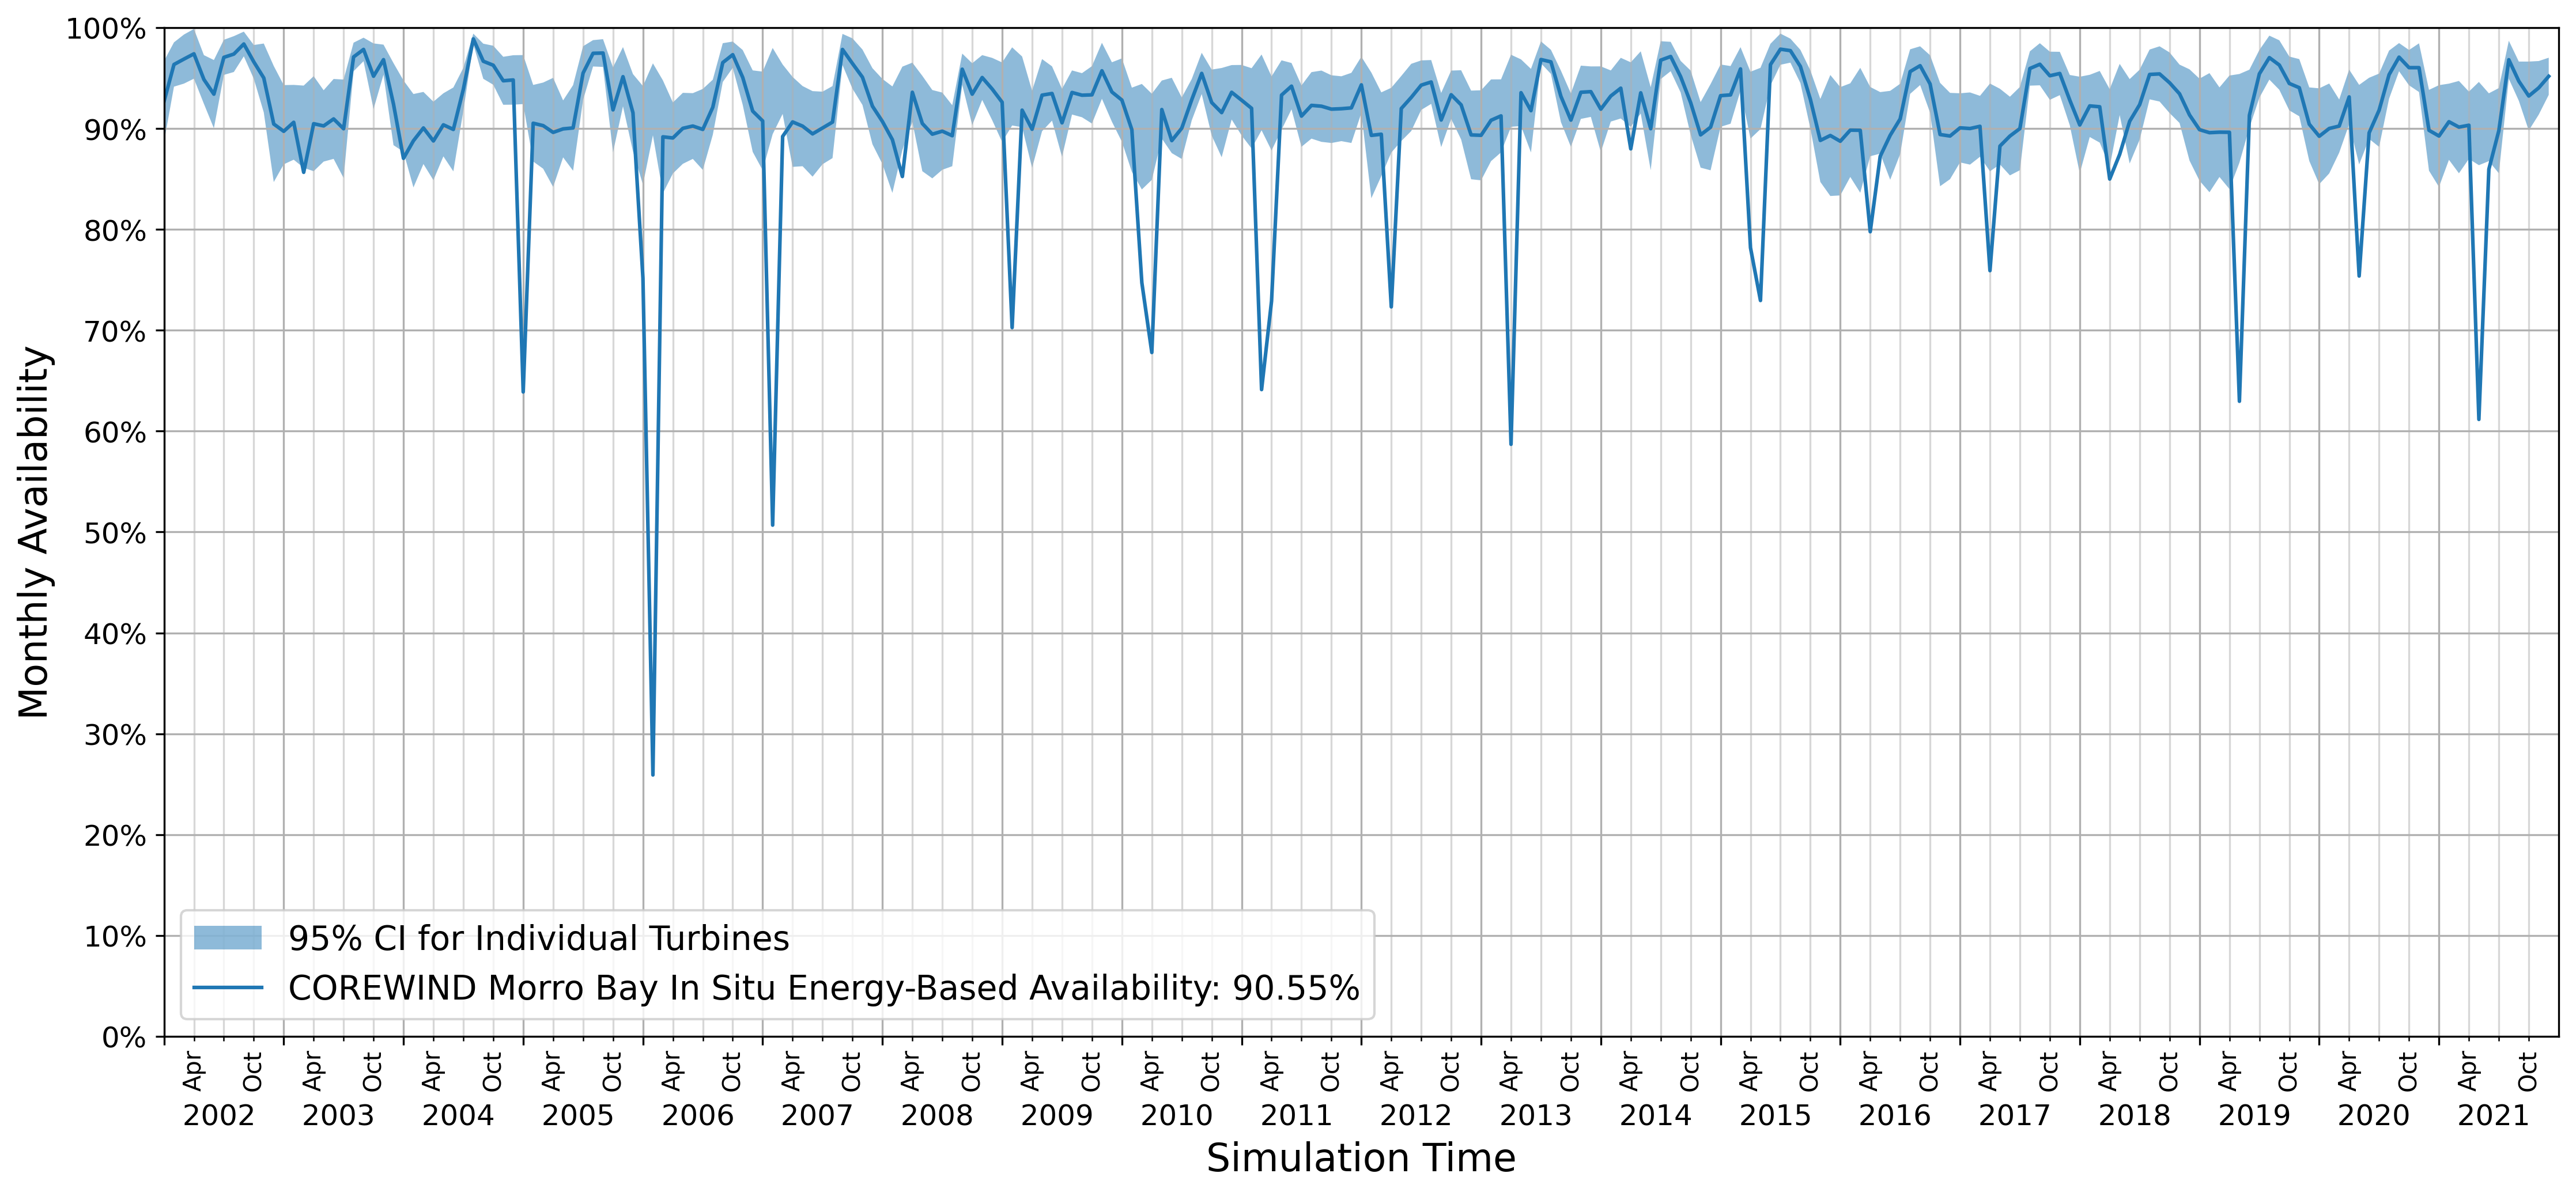

In [9]:
# Demonstrate the granular monthly reporting
plot.plot_farm_availability(sim=sim, which="energy", farm_95_CI=True)

(metrics-demo:cf)=
## Capacity Factor

The capacity factor is the ratio of actual (net) or potential (gross) energy production
divided by the project's capacity. For further documentation, see the API docs here:
{py:meth}`wombat.core.post_processor.Metrics.capacity_factor`.

**Inputs**:

- `which`
  - "net": net capacity factor, actual production divided by the plant capacity
  - "gross": gross capacity factor, potential production divided by the plant capacity
- `frequency`, as explained [above](metrics-demo:common-parameters), options: "project",
  "annual", "monthly", and "month-year"
- `by`, as explained [above](metrics-demo:common-parameters), options: "windfarm" and
  "turbine"

**Example Usage**:

In [10]:
net_cf = metrics.capacity_factor(
    which="net", frequency="project", by="windfarm"
).values[0][0]
gross_cf = metrics.capacity_factor(
    which="gross", frequency="project", by="windfarm"
).values[0][0]
print(f"  Net capacity factor: {net_cf:.2%}")
print(f"Gross capacity factor: {gross_cf:.2%}")

  Net capacity factor: 51.48%
Gross capacity factor: 55.59%


(metrics-demo:task-completion)=
## Task Completion Rate

The task completion rate is the ratio of tasks completed aggregated to the desired
`frequency`. It is possible to have a >100% completion rate if all maintenance and
failure requests submitted in a time period were completed in addition to those that
went unfinished in prior time periods. For further documentation, see the API docs here:
{py:meth}`wombat.core.post_processor.Metrics.task_completion_rate`.

**Inputs**:

- `which`
  - "scheduled": scheduled maintenance only (classified as maintenance tasks in inputs)
  - "unscheduled": unscheduled maintenance only (classified as failure events in inputs)
  - "both": Combined completion rate for all tasks
- `frequency`, as explained [above](metrics-demo:common-parameters), options: "project",
  "annual", "monthly", and "month-year"

**Example Usage**:

In [11]:
scheduled = metrics.task_completion_rate(which="scheduled", frequency="project").values[
    0
][0]
unscheduled = metrics.task_completion_rate(
    which="unscheduled", frequency="project"
).values[0][0]
combined = metrics.task_completion_rate(which="both", frequency="project").values[0][0]
print(f"  Scheduled Task Completion Rate: {scheduled:.2%}")
print(f"Unscheduled Task Completion Rate: {unscheduled:.2%}")
print(f"    Overall Task Completion Rate: {combined:.2%}")

  Scheduled Task Completion Rate: 96.57%
Unscheduled Task Completion Rate: 96.23%
    Overall Task Completion Rate: 96.35%


(metrics-demo:equipment-costs)=
## Equipment Costs

Sum of the costs associated with a simulation's servicing equipment, which excludes
materials, downtime, etc. For further documentation, see the API docs here:
{py:meth}`wombat.core.post_processor.Metrics.equipment_costs`.

**Inputs**:

- `frequency`, as explained [above](metrics-demo:common-parameters), options: "project",
  "annual", "monthly", and "month-year"
- `by_equipment`
  - `True`: Aggregates all equipment into a single cost
  - `False`: Computes for each unit of servicing equipment

**Example Usage**:

In [12]:
# Project total at the whole wind farm level
style(metrics.equipment_costs(frequency="project", by_equipment=False))

,equipment_cost
0,"2,334,830,137.08"


In [13]:
# Project totals at servicing equipment level
style(metrics.equipment_costs(frequency="project", by_equipment=True))

/Users/rhammond/GitHub_Public/WOMBAT/wombat/core/post_processor.py:731: FutureWarning: <class 'pandas.core.arrays.string_.StringArray'>._reduce will require a `keepdims` parameter in the future
  costs = costs.fillna(costs.max(axis=0)).T


,Anchor Handling Tug,Cable Laying Vessel,Crew Transfer Vessel 1,Crew Transfer Vessel 2,Crew Transfer Vessel 3,Crew Transfer Vessel 4,Crew Transfer Vessel 5,Crew Transfer Vessel 6,Crew Transfer Vessel 7,Diving Support Vessel,Heavy Lift Vessel
0,"125,478,011.51","188,391,390.92","25,563,218.06","25,563,194.00","25,563,194.53","25,563,169.23","25,563,198.26","25,563,217.01","25,563,180.17","145,375,044.81","1,696,643,318.56"


(metrics-demo:utilization-rate)=
## Service Equipment Utilization Rate

Ratio of days when the servicing equipment is in use (not delayed for a whole day due to
either weather or lack of repairs to be completed) to the number of days it's present in
the simulation. For further documentation, see the API docs here:
{py:meth}`wombat.core.post_processor.Metrics.service_equipment_utilization`.

**Inputs**:

- `frequency`, as explained [above](metrics-demo:common-parameters), options: "project"
  and "annual"

**Example Usage**:

In [14]:
# Project totals
style(metrics.service_equipment_utilization(frequency="project"))

,Anchor Handling Tug,Cable Laying Vessel,Crew Transfer Vessel 1,Crew Transfer Vessel 2,Crew Transfer Vessel 3,Crew Transfer Vessel 4,Crew Transfer Vessel 5,Crew Transfer Vessel 6,Crew Transfer Vessel 7,Diving Support Vessel,Heavy Lift Vessel
0,0.86,0.93,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.88,0.97


(metrics-demo:vessel-crew-hours)=
## Vessel-Crew Hours at Sea

The number of vessel hours or crew hours at sea for offshore wind power plant
simulations. For further documentation, see the API docs here:
{py:meth}`wombat.core.post_processor.Metrics.vessel_crew_hours_at_sea`.

**Inputs**:

- `frequency`, as explained [above](metrics-demo:common-parameters), options: "project",
  "annual", "monthly", and "month-year"
- `by_equipment`
  - `True`: Aggregates all equipment into a single cost
  - `False`: Computes for each unit of servicing equipment
- `vessel_crew_assumption`: A dictionary of vessel names
  (`ServiceEquipment.settings.name`, but also found at `Metrics.service_equipment_names`)
  and the number of crew onboard at any given time. The application of this assumption
  transforms the results from vessel hours at sea to crew hours at sea.

**Example Usage**:

In [15]:
# Project total, not broken out by vessel
style(metrics.vessel_crew_hours_at_sea(frequency="project", by_equipment=False))

,Total Crew Hours at Sea
0,"699,544.52"


In [16]:
# Annual project totals, broken out by vessel
style(metrics.vessel_crew_hours_at_sea(frequency="annual", by_equipment=True))

,Total Crew Hours at Sea,Crew Transfer Vessel 1,Crew Transfer Vessel 2,Crew Transfer Vessel 3,Crew Transfer Vessel 4,Crew Transfer Vessel 5,Crew Transfer Vessel 6,Crew Transfer Vessel 7,Heavy Lift Vessel,Anchor Handling Tug,Cable Laying Vessel,Diving Support Vessel
year,,,,,,,,,,,,
2002,"21,971.83","1,412.17","1,062.54","1,280.85","1,159.44","1,449.26","1,689.49","1,272.64","6,961.68","1,866.42","3,817.32",0.00
2003,"30,519.85","2,528.69","2,647.51","2,627.23","2,505.95","2,692.68","2,716.93","2,933.81","6,951.94","2,346.89","2,568.22",0.00
2004,"36,175.26","2,438.00","2,369.40","2,575.70","2,553.75","2,385.49","2,380.19","2,716.73","6,977.37","3,707.18","2,022.44","6,049.01"
2005,"29,813.97","2,566.83","2,138.82","2,568.34","2,331.38","2,581.68","2,294.82","2,240.38","7,636.07","2,326.45","2,019.69","1,109.51"
2006,"38,359.26","2,646.93","2,347.57","2,430.38","2,507.73","2,648.05","2,440.37","2,443.31","6,904.01","4,556.07","2,994.19","6,440.67"
2007,"32,330.05","2,615.29","2,598.58","2,520.83","2,362.07","2,501.41","2,461.72","2,322.59","7,505.44","2,014.00","4,232.61","1,195.51"
2008,"37,869.64","2,657.53","2,595.36","2,572.30","2,535.46","2,568.42","2,783.99","2,433.01","7,521.73","1,963.54","4,127.38","6,110.93"
2009,"33,582.31","2,653.70","2,731.61","2,446.62","2,308.56","2,446.95","2,382.45","2,536.78","7,850.05","2,745.83","3,484.59","1,995.17"
2010,"41,959.89","2,790.53","2,522.15","2,498.18","2,554.83","2,656.66","2,548.96","2,589.44","7,902.25","4,501.65","5,550.87","5,844.37"


(metrics-demo:n-tows)=
## Number of Tows

The number of tows performed during the simulation. If tow-to-port was not used in the
simulation, a DataFrame with a single value of 0 will be returned. For further
documentation, see the API docs here:
{py:meth}`wombat.core.post_processor.Metrics.number_of_tows`.

**Inputs**:

- `frequency`, as explained [above](metrics-demo:common-parameters), options: "project",
  "annual", "monthly", and "month-year"
- `by_tug`
  - `True`: Computed for each tugboat (towing vessel)
  - `False`: Aggregates all the tugboats
- `by_direction`
  - `True`: Computed for each direction a tow was performed (to port or to site)
  - `False`: Aggregates to the total number of tows

**Example Usage**:

In [17]:
# Project Total
# NOTE: This example has no towing, so it will return 0
style(metrics.number_of_tows(frequency="project"))

,total_tows
0,0


(metrics-demo:labor-costs)=
## Labor Costs

Sum of all labor costs associated with servicing equipment, excluding the labor defined
in the fixed costs, which can be broken out by type. For further documentation, see the
API docs here: {py:meth}`wombat.core.post_processor.Metrics.labor_costs`.

**Inputs**:

- `frequency`, as explained [above](metrics-demo:common-parameters), options: "project",
  "annual", "monthly", and "month-year"
- `by_type`
  - `True`: Computed for each labor type (salary and hourly)
  - `False`: Aggregates all the labor costs

**Example Usage**:

In [18]:
# Project total at the whole wind farm level
total = metrics.labor_costs(frequency="project", by_type=False)
print(f"Project total: ${total.values[0][0] / metrics.project_capacity:,.2f}/MW")

Project total: $42,687.16/MW


In [19]:
# Project totals for each type of labor
style(metrics.labor_costs(frequency="project", by_type=True))

,hourly_labor_cost,salary_labor_cost,total_labor_cost
0,0.00,"51,224,592.60","51,224,592.60"


(metrics-demo:equipment-labor-costs)=
## Equipment and Labor Costs

Sum of all labor and servicing equipment costs, excluding the labor defined in the fixed
costs, which can be broken out by each category. For further documentation, see the API
docs here: {py:meth}`wombat.core.post_processor.Metrics.equipment_labor_cost_breakdown`.

**Inputs**:

- `frequency`, as explained [above](metrics-demo:common-parameters), options: "project",
  "annual", "monthly", and "month-year"
- `by_category`
  - `True`: Computed for each unit servicing equipment and labor category
  - `False`: Aggregated to the sum of all costs

`reason` definitions:

- Maintenance: routine maintenance, or events defined as a
  {py:class}`wombat.core.data_classes.Maintenance`
- Repair: unscheduled maintenance, ranging from inspections to replacements, or events
  defined as a {py:class}`wombat.core.data_classes.Failure`
- Mobilization: Cost of mobilizing servicing equipment
- Crew Transfer: Costs incurred while crew are transferring between a turbine or
  substation and the servicing equipment
- Site Travel: Costs incurred while transiting to/from the site and while at the site
- Weather Delay: Any delays caused by unsafe weather conditions
- No Requests: Equipment and labor is active, but there are no repairs or maintenance
  tasks to be completed
- Not in Shift: Any time outside the operating hours of the wind farm (or the
  servicing equipment's specific operating hours)

**Example Usage**:

In [20]:
# Project totals
style(metrics.equipment_labor_cost_breakdowns(frequency="project", by_category=False))

,total_cost,total_hours
reason,,
Maintenance,"23,088,612.18","72,255.63"
Repair,"603,314,310.75","168,023.02"
Crew Transfer,"9,390,720.68","11,229.75"
Site Travel,"96,428,295.19","124,071.17"
Mobilization,"133,935,000.00","150,360.00"
Weather Delay,"1,387,380,093.14","611,231.19"
No Requests,"105,474,202.91","394,662.82"
Not in Shift,"27,043,494.82","106,658.75"


In [21]:
# Project totals by each category
style(metrics.equipment_labor_cost_breakdowns(frequency="project", by_category=True))

,hourly_labor_cost,salary_labor_cost,total_labor_cost,equipment_cost,total_cost,total_hours
reason,,,,,,
Maintenance,0,"2,201,707.77","2,201,707.77","20,886,904.42","23,088,612.18","72,255.63"
Repair,0,"8,128,930.52","8,128,930.52","595,185,380.23","603,314,310.75","168,023.02"
Crew Transfer,0,"351,585.27","351,585.27","9,039,135.42","9,390,720.68","11,229.75"
Site Travel,0,"3,929,059.94","3,929,059.94","92,499,235.25","96,428,295.19","124,071.17"
Mobilization,0,0.00,0.00,"133,935,000.00","133,935,000.00","150,360.00"
Weather Delay,0,"22,291,230.90","22,291,230.90","1,365,088,862.24","1,387,380,093.14","611,231.19"
No Requests,0,"11,256,405.52","11,256,405.52","94,217,797.40","105,474,202.91","394,662.82"
Not in Shift,0,"3,065,672.69","3,065,672.69","23,977,822.12","27,043,494.82","106,658.75"


(metrics-demo:emissions)=
## Emissions

Emissions (tons or other provided units) of all servicing equipment activity, except
overnight waiting periods between shifts. For further documentation, see the API docs
here: {py:meth}`wombat.core.post_processor.Metrics.emissions`.

**Inputs**:

- `emissions_factors`: Dictionary of servicing equipment names and the emissions per
  hour of the following activities: `transit`, `maneuvering`, `idle at site`, and
  `idle at port`, where port is stand-in for wherever the servicing equipment might be
  based when not at site.
- `maneuvering_factor`: The proportion of transit time that can generally be associated
  with positioning servicing, by default 10%.
- `port_engine_on_factor`: The proportion of the idling at port time when the engine is
  running and producing emissions, by default 25%.

In [22]:
# Create the emissions factors, in tons per hour
emissions_factors = {
    "Crew Transfer Vessel 1": {
        "transit": 4,
        "maneuvering": 3,
        "idle at site": 0.5,
        "idle at port": 0.25,
    },
    "Crew Transfer Vessel 2": {
        "transit": 4,
        "maneuvering": 3,
        "idle at site": 0.5,
        "idle at port": 0.25,
    },
    "Crew Transfer Vessel 3": {
        "transit": 4,
        "maneuvering": 3,
        "idle at site": 0.5,
        "idle at port": 0.25,
    },
    "Field Support Vessel": {
        "transit": 6,
        "maneuvering": 4,
        "idle at site": 1,
        "idle at port": 0.5,
    },
    "Heavy Lift Vessel": {
        "transit": 12,
        "maneuvering": 7,
        "idle at site": 1,
        "idle at port": 0.5,
    },
}

style(
    metrics.emissions(
        emissions_factors=emissions_factors,
        maneuvering_factor=0.075,
        port_engine_on_factor=0.20,
    )
)

KeyError: "`emissions_factors` is missing the following keys: {'Crew Transfer Vessel 4', 'Cable Laying Vessel', 'Crew Transfer Vessel 6', 'Crew Transfer Vessel 7', 'Crew Transfer Vessel 5', 'Diving Support Vessel', 'Anchor Handling Tug'}"

(metrics-demo:component-costs)=
## Component Costs

All the costs associated with maintenance and failure events during the simulation,
including delays incurred during the repair process, but excluding costs not directly
tied to a repair. For further documentation, see the API docs here:
{py:meth}`wombat.core.post_processor.Metrics.component_costs`.

**Inputs**:

- `frequency`, as explained [above](metrics-demo:common-parameters), options: "project",
  "annual", "monthly", and "month-year"
- `by_category`
  - `True`: Computed across each cost category
  - `False`: Aggregated to the sum of all categories
- `by_action`
  - `True`: Computed by each of "repair", "maintenance", and "delay", and is included in
    the MultiIndex
  - `False`: Aggregated as the sum of all actions

`action` definitions:

- maintenance: routine maintenance
- repair: unscheduled maintenance, ranging from inspections to replacements
- delay: Any delays caused by unsafe weather conditions or not being able to finish a
  process within a single shift

**Example Usage**:

In [23]:
# Project totals by component
style(metrics.component_costs(frequency="project", by_category=False, by_action=False))

,total_cost
component,
cable,"195,992,289.24"
drive_train,"158,032,882.75"
electrical_system,"1,126,832,651.47"
generator,"313,201,511.54"
hydraulic_system,"45,400,030.93"
rotor_blades,"106,650,585.37"
supporting_structure,"234,675,387.98"
transformer,"1,345,543.02"
yaw_system,"21,355,712.07"


In [24]:
# Project totals by each category and action type
style(metrics.component_costs(frequency="project", by_category=True, by_action=True))

(metrics-demo:fixed-costs)=
## Fixed Cost Impacts

Computes the total costs of the fixed costs categories. For further documentation, see
the definition docs, here: {py:class}`wombat.core.data_classes.FixedCosts`, or the API
docs here: {py:meth}`wombat.core.post_processor.Metrics.fixed_costs`.

**Inputs**:

- `frequency`, as explained [above](metrics-demo:common-parameters), options: "project",
  "annual", "monthly", and "month-year"
- `resolution` (also, demonstrated below)
  - "high": Computed across the most granular cost levels
  - "medium": Computed for each general cost category
  - "low": Aggregated to a single sum of costs

In [25]:
pprint(metrics.fixed_costs.hierarchy)

{'operations': {'annual_leases_fees': ['submerge_land_lease_costs',
                                       'transmission_charges_rights'],
                'environmental_health_safety_monitoring': [],
                'insurance': ['brokers_fee',
                              'operations_all_risk',
                              'business_interruption',
                              'third_party_liability',
                              'storm_coverage'],
                'labor': [],
                'onshore_electrical_maintenance': [],
                'operating_facilities': [],
                'operations_management_administration': ['project_management_administration',
                                                         'marine_management',
                                                         'weather_forecasting',
                                                         'condition_monitoring']}}


**Example Usage**:

In [26]:
# Project totals at the highest level
# NOTE: there were no fixed costs defined in this example, so all values will be 0, so
#       this will just be demonstrating the output format
style(metrics.project_fixed_costs(frequency="project", resolution="low"))

,operations
0,0.00


In [27]:
# Project totals at the medium level
style(metrics.project_fixed_costs(frequency="project", resolution="medium"))

,operations_management_administration,insurance,annual_leases_fees,operating_facilities,environmental_health_safety_monitoring,onshore_electrical_maintenance,labor
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [28]:
# Project totals at the lowest level
style(metrics.project_fixed_costs(frequency="project", resolution="high"))

,project_management_administration,marine_management,weather_forecasting,condition_monitoring,brokers_fee,operations_all_risk,business_interruption,third_party_liability,storm_coverage,submerge_land_lease_costs,transmission_charges_rights,operating_facilities,environmental_health_safety_monitoring,onshore_electrical_maintenance,labor
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


(metrics-demo:opex)=
## OpEx

Computes the total cost of all operating expenditures for the duration of the
simulation, including fixed costs. For further documentation, see the API docs here:
{py:meth}`wombat.core.post_processor.Metrics.opex`.

**Inputs**:

- `frequency`, as explained [above](metrics-demo:common-parameters), options: "project",
  "annual", "monthly", and "month-year"

- `by_category`
  - `True` shows the port fees, fixed costs, labor costs, equipment costs, and materials
    costs in addition the total OpEx
  - `False` shows only the total OpEx

**Example Usage**:

In [29]:
style(metrics.opex("annual"))

/Users/rhammond/GitHub_Public/WOMBAT/wombat/core/post_processor.py:1955: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  port_fees = port_fees.fillna(0)


,OpEx
year,
2002,"105,976,723.31"
2003,"106,101,689.56"
2004,"110,913,687.57"
2005,"114,346,312.59"
2006,"125,111,460.54"
2007,"119,404,655.24"
2008,"132,638,281.48"
2009,"124,058,023.94"
2010,"136,082,069.71"


In [30]:
style(metrics.opex("annual", by_category=True))

/Users/rhammond/GitHub_Public/WOMBAT/wombat/core/post_processor.py:1955: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  port_fees = port_fees.fillna(0)


,operations,port_fees,equipment_cost,total_labor_cost,materials_cost,OpEx
year,,,,,,
2002,0.00,0,"101,779,810.91","2,335,860.40","1,861,052.00","105,976,723.31"
2003,0.00,0,"100,952,067.07","2,281,342.50","2,868,280.00","106,101,689.56"
2004,0.00,0,"105,008,638.51","2,533,909.06","3,371,140.00","110,913,687.57"
2005,0.00,0,"109,353,984.99","2,298,155.60","2,694,172.00","114,346,312.59"
2006,0.00,0,"118,866,905.14","2,690,815.40","3,553,740.00","125,111,460.54"
2007,0.00,0,"114,112,221.37","2,471,829.88","2,820,604.00","119,404,655.24"
2008,0.00,0,"127,635,447.91","2,699,573.57","2,303,260.00","132,638,281.48"
2009,0.00,0,"118,708,191.75","2,495,052.20","2,854,780.00","124,058,023.94"
2010,0.00,0,"129,887,553.55","2,922,244.16","3,272,272.00","136,082,069.71"


(metrics-demo:process-times)=
## Process Times

Computes the total number of hours spent from repair request submission to completion,
performing repairs, and the number of request for each repair category. For further
documentation, see the API docs here:
{py:meth}`wombat.core.post_processor.Metrics.process_times`.

**Example Usage**:

In [31]:
style(metrics.process_times())

,time_to_completion,process_time,downtime,time_to_start,N
category,,,,,
anchor replacement,"24,539.90","12,608.08","12,606.83","12,266.16",25
annual turbine inspection,"1,314,609.32","173,093.17","171,573.41","1,155,241.75","1,435"
array cable major repair,"37,567.33","21,904.60",0.00,"16,640.43",41
array cable replacement,"54,205.69","34,288.93",0.00,"21,740.56",43
blades major repair,"19,149.44","1,402.07","1,398.43","17,881.19",12
blades major replacement,"6,852.11","5,787.74","5,787.03","1,245.06",2
blades minor repair,"118,495.37","78,015.59","77,411.56","53,048.32",707
buoyancy module replacement,"11,103.29","8,433.72","8,415.60","3,589.97",41
direct drive generator major repair,"132,226.95","9,017.72","9,000.98","124,224.57",47


(metrics-demo:power-production)=
## Power Production

Computes the total power production for the wind farm. For further documentation, see
the API docs here: {py:meth}`wombat.core.post_processor.Metrics.power_production`.

**Inputs**:

- `frequency`, as explained [above](metrics-demo:common-parameters), options: "project",
  "annual", "monthly", and "month-year"
- `by`, as explained [above](metrics-demo:common-parameters) options: "windfarm" and "turbine"
- `units`
  - "kwh": kilowatt-hours (kWh)
  - "mwh": megawatt-hours (MWh)
  - "gwh": gigawatt-hours (GWh)

**Example Usage**:

In [32]:
# Project totals, in kWh, at the wind farm level
style(metrics.power_production(frequency="project", by="windfarm", units="kwh"))

,windfarm
Project Energy Production (kWh),"105,903,690,137.50"


In [33]:
# Project totals, in MWh, at the wind farm level
style(metrics.power_production(frequency="project", units="mwh"))

,windfarm
Project Energy Production (MWh),"105,903,690.14"


In [34]:
# Project totals, in GWh, at the wind farm level
style(metrics.power_production(frequency="project"))

,windfarm
Project Energy Production (GWh),"105,903.69"


(metrics-demo:npv)=
## Net Present Value

Calcualtes the net present value (NPV) for the project, as
$NPV = (Power * OfftakePrice - OpEx) / (1 + DiscountRate)$.

For further documentation, see the API docs here: {py:meth}`wombat.core.post_processor.Metrics.npv`.

**Inputs**:

- `frequency`, as explained [above](metrics-demo:common-parameters), options: "project",
  "annual", "monthly", and "month-year"
- `discount_rate`: The rate of return that could be earned on alternative investments,
  by default 0.025.
- `offtake_price`: Price of energy, per MWh, by default 80.

In [35]:
style(metrics.opex("annual"))

/Users/rhammond/GitHub_Public/WOMBAT/wombat/core/post_processor.py:1955: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  port_fees = port_fees.fillna(0)


,OpEx
year,
2002,"105,976,723.31"
2003,"106,101,689.56"
2004,"110,913,687.57"
2005,"114,346,312.59"
2006,"125,111,460.54"
2007,"119,404,655.24"
2008,"132,638,281.48"
2009,"124,058,023.94"
2010,"136,082,069.71"
